# TRACE Data Preparation

Merge TRACE transaction data with HY bond metadata.

## Pipeline:
1. Load raw TRACE data
2. Load HY universe metadata
3. Filter: dealer-to-customer, size ≥$100k, trading hours
4. Merge TRACE with bond characteristics
5. Keep last trade per day per CUSIP
6. Remove weekends and SIFMA holidays
7. Export merged dataset

## Output:
- `trace_hy_merged.csv` - TRACE + bond metadata, ready for modeling

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("Imports complete")

Imports complete


In [2]:
# Set data directory to current working directory
DATA_DIR = Path.cwd()
OUTPUT_DIR = Path.cwd()

print(f"Data/Output directory: {DATA_DIR}")
print(f"\nExpected files:")
print(f"  - hy_universe.csv")
print(f"  - hy_traces_2025.csv")

# Verify files exist
hy_universe_file = DATA_DIR / 'hy_universe.csv'
hy_traces_file = DATA_DIR / 'hy_traces_2025.csv'

if not hy_universe_file.exists():
    raise FileNotFoundError(f"hy_universe.csv not found in {DATA_DIR}")
if not hy_traces_file.exists():
    raise FileNotFoundError(f"hy_traces_2025.csv not found in {DATA_DIR}")

print(f"\n✓ All required files found")

Data/Output directory: /Users/oualid/Documents/Teaching/Baruch/DL_for_Finance/repo/DLinFinance_BaruchMFE2025/homeworks/week4/assignment

Expected files:
  - hy_universe.csv
  - hy_traces_2025.csv

✓ All required files found


## 2. Load Data

In [3]:
# Load HY universe
hy_universe = pd.read_csv(DATA_DIR / 'hy_universe.csv', parse_dates=['maturity', 'offering_date'])

print(f"HY Universe: {len(hy_universe):,} bonds")
print(f"Columns: {len(hy_universe.columns)}")
print(f"\nSample:")
hy_universe.head()

HY Universe: 3,973 bonds
Columns: 33

Sample:


,cusip_9,isin,issue_cusip,complete_cusip,issue_id,maturity,offering_date,issue_name,coupon_type,coupon_type_label,offering_yield,security_level,seniority,bond_type,offering_amt,principal_amt,issuer_id,cusip_name,industry_group,industry_code,naics_code,naics_2digit,sector,rating,rating_type,rating_date,convertible,redeemable,putable,rule_144a,amount_outstanding,amount_outstanding_date,rating_broad
0,90933HAA3,US90933HAA32,AA3,90933HAA3,717571,2026-01-07,2017-10-23,PASSTHRU CTF CL B,F,Fixed,3.650,NON,Not Specified,CPAS,258348.0,1000.0,47973.0,UNITED AIRLS 2016-1 CL B PASSTHRU TR,1.0,16,481111.0,48,Transportation,Ba2,MR,2023-10-18,N,Y,N,N,258348.0,2017-10-23,BB
1,345397XU2,US345397XU23,XU2,345397XU2,645865,2026-01-08,2016-01-05,GLOBAL NT,F,Fixed,4.389,SEN,Senior Unsecured,CDEB,1200000.0,1000.0,1664.0,FORD MTR CR CO,2.0,21,52222.0,52,Finance & Insurance,BB+,FR,2022-05-02,N,N,N,N,1200000.0,2016-01-05,BB
2,588056AW1,US588056AW17,AW1,588056AW1,775751,2026-01-15,2018-08-10,SR NT,F,Fixed,NaN,SEN,Senior Unsecured,CDEB,300000.0,1000.0,38242.0,MERCER INTL INC,1.0,10,322120.0,32,Manufacturing,B2,MR,2023-09-08,N,Y,N,N,0.0,2024-11-01,B
3,36740LAA0,US36740LAA08,AA0,36740LAA0,864987,2026-01-15,2019-11-20,GTD SR NT RULE 144A,F,Fixed,6.250,SEN,Senior Unsecured,CDEB,568000.0,1000.0,49987.0,GATES GLOBAL LLC / GATES CORP,1.0,10,326199.0,32,Manufacturing,B+,SPR,2024-02-20,N,Y,N,Y,568000.0,2019-11-20,B
4,40204BAA3,US40204BAA35,AA3,40204BAA3,1025610,2026-01-15,2020-12-08,SR SECD NT RULE 144A,F,Fixed,8.500,SS,Senior Subordinated,CDEB,350000.0,1000.0,51548.0,GUITAR CTR ESCROW II INC,5.0,11,459140.0,45,Retail Trade,Caa2,MR,2024-02-02,N,Y,N,Y,550000.0,2022-03-17,CCC


In [4]:
# Load TRACE data
trace = pd.read_csv(
    DATA_DIR / 'hy_traces_2025.csv',
    parse_dates=['trd_exctn_dt', 'trd_exctn_tm'],
    low_memory=False
)

print(f"TRACE records: {len(trace):,}")
print(f"\nColumns: {list(trace.columns)}")
print(f"\nDate range: {trace['trd_exctn_dt'].min()} to {trace['trd_exctn_dt'].max()}")
print(f"\nSample:")
trace.head(10)

TRACE records: 1,156,793

Columns: ['Unnamed: 0', 'cusip_id', 'bond_sym_id', 'company_symbol', 'bsym', 'trd_exctn_dt', 'trd_exctn_tm', 'sub_prd_type', 'trans_dt', 'msg_seq_nb', 'trc_st', 'wis_fl', 'cmsn_trd', 'remuneration', 'ascii_rptd_vol_tx', 'frmt_cd', 'rptd_pr', 'yld_sign_cd', 'yld_pt', 'asof_cd', 'days_to_sttl_ct', 'sale_cndtn_cd', 'sale_cndtn2_cd', 'spcl_trd_fl', 'diss_rptg_side_cd', 'side', 'chng_cd', 'rptd_high_pr', 'high_yld_sign_cd', 'high_yld_pt', 'rptd_low_pr', 'low_yld_sign_cd', 'low_yld_pt', 'rptd_last_pr', 'lsal_yld_sign_cd', 'lsal_yld_pt', 'orig_dis_dt', 'orig_msg_seq_nb', 'function', 'sttl_dt', 'rptg_party_type', 'contra_party_type', 'ats_indicator', 'orig_frmt_cd', 'orig_ascii_rptd_vol_tx', 'orig_rptd_pr', 'orig_remuneration', 'orig_spcl_trd_fl', 'orig_side', 'orig_asof_cd', 'orig_sale_cndtn_cd', 'orig_sale_cndtn2_cd', 'orig_sttl_dt', 'orig_yld_sign_cd', 'orig_yld_pt', 'orig_wis_fl', 'orig_rptg_party_type', 'orig_contra_party_type', 'orig_ats_indicator', 'issuer', 'a

,Unnamed: 0,cusip_id,bond_sym_id,company_symbol,bsym,trd_exctn_dt,trd_exctn_tm,sub_prd_type,trans_dt,msg_seq_nb,trc_st,wis_fl,cmsn_trd,remuneration,ascii_rptd_vol_tx,frmt_cd,rptd_pr,yld_sign_cd,yld_pt,asof_cd,days_to_sttl_ct,sale_cndtn_cd,sale_cndtn2_cd,spcl_trd_fl,diss_rptg_side_cd,side,chng_cd,rptd_high_pr,high_yld_sign_cd,high_yld_pt,rptd_low_pr,low_yld_sign_cd,low_yld_pt,rptd_last_pr,lsal_yld_sign_cd,lsal_yld_pt,orig_dis_dt,orig_msg_seq_nb,function,sttl_dt,rptg_party_type,contra_party_type,ats_indicator,orig_frmt_cd,orig_ascii_rptd_vol_tx,orig_rptd_pr,orig_remuneration,orig_spcl_trd_fl,orig_side,orig_asof_cd,orig_sale_cndtn_cd,orig_sale_cndtn2_cd,orig_sttl_dt,orig_yld_sign_cd,orig_yld_pt,orig_wis_fl,orig_rptg_party_type,orig_contra_party_type,orig_ats_indicator,issuer,action,action_date_time,halt_reason,text,orig_trd_exctn_dt,orig_trd_exctn_tm
0,0,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-02,2025-11-24 10:16:04,CORP,2025-01-02,29767.0,M,NaN,NaN,NaN,5000,A,70.500,NaN,8.041952,NaN,NaN,NaN,NaN,NaN,NaN,S,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-03,D,D,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-02,2025-11-24 10:16:04,CORP,2025-01-02,29862.0,M,NaN,NaN,NaN,5000,A,70.500,NaN,8.041952,NaN,NaN,NaN,NaN,NaN,NaN,S,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-03,D,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-02,2025-11-24 10:16:04,CORP,2025-01-02,29863.0,M,NaN,NaN,M,5000,A,70.600,NaN,8.028290,NaN,NaN,NaN,NaN,NaN,NaN,S,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-03,D,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-02,2025-11-24 13:42:11,CORP,2025-01-02,112037.0,M,NaN,NaN,NaN,10000,A,70.349,NaN,8.062633,NaN,NaN,NaN,NaN,NaN,NaN,S,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-03,D,D,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-02,2025-11-24 13:42:11,CORP,2025-01-02,112078.0,M,NaN,NaN,M,10000,A,70.449,NaN,8.048930,NaN,NaN,NaN,NaN,NaN,NaN,S,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-03,D,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-02,2025-11-24 13:42:11,CORP,2025-01-02,112127.0,M,NaN,NaN,NaN,10000,A,70.349,NaN,8.062633,NaN,NaN,NaN,NaN,NaN,NaN,S,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-03,D,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-02,2025-11-24 15:34:39,CORP,2025-01-02,157302.0,M,NaN,NaN,M,25000,A,68.500,NaN,8.320995,NaN,NaN,NaN,NaN,NaN,NaN,B,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-03,D,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-03,2025-11-24 09:37:28,CORP,2025-01-03,15942.0,M,NaN,NaN,NaN,10000,A,70.500,NaN,8.042938,NaN,NaN,NaN,NaN,NaN,NaN,S,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-06,D,D,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-03,2025-11-24 09:37:28,CORP,2025-01-03,15995.0,M,NaN,NaN,M,10000,A,70.600,NaN,8.029272,NaN,NaN,NaN,NaN,NaN,NaN,S,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-06,D,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,00101JAG1,ADT3991007,ADT,BBG004DGLWF1,2025-01-03,2025-11-24 09:37:28,CORP,2025-01-03,15997.0,M,NaN,NaN,NaN,10000,A,70.500,NaN,8.042938,NaN,NaN,NaN,NaN,NaN,NaN,S,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025

In [5]:
trace['tradeDate'] = pd.to_datetime(trace['trd_exctn_dt']).dt.date

In [6]:
trace.groupby('tradeDate')['cusip_id'].nunique().describe()

count    179.000000
mean     470.469274
std      166.839736
min        1.000000
25%      513.000000
50%      528.000000
75%      541.000000
max      572.000000
Name: cusip_id, dtype: float64

## 3. Clean TRACE Data

Apply filters:
1. Dealer-to-Customer trades only
2. Trade size ≥ $100,000
3. Trading hours: 8:30 AM - 6:00 PM ET
4. Keep last trade per day per CUSIP

In [7]:
trace = trace[trace['side'].isin(['B', 'S'])]


In [8]:
trace = trace[trace['rptg_party_type'].isin(['D'])]
trace = trace[trace['contra_party_type'].isin(['C'])]
trace = trace[trace['ats_indicator'].isna()]



In [9]:
trace.columns.tolist()

['Unnamed: 0',
 'cusip_id',
 'bond_sym_id',
 'company_symbol',
 'bsym',
 'trd_exctn_dt',
 'trd_exctn_tm',
 'sub_prd_type',
 'trans_dt',
 'msg_seq_nb',
 'trc_st',
 'wis_fl',
 'cmsn_trd',
 'remuneration',
 'ascii_rptd_vol_tx',
 'frmt_cd',
 'rptd_pr',
 'yld_sign_cd',
 'yld_pt',
 'asof_cd',
 'days_to_sttl_ct',
 'sale_cndtn_cd',
 'sale_cndtn2_cd',
 'spcl_trd_fl',
 'diss_rptg_side_cd',
 'side',
 'chng_cd',
 'rptd_high_pr',
 'high_yld_sign_cd',
 'high_yld_pt',
 'rptd_low_pr',
 'low_yld_sign_cd',
 'low_yld_pt',
 'rptd_last_pr',
 'lsal_yld_sign_cd',
 'lsal_yld_pt',
 'orig_dis_dt',
 'orig_msg_seq_nb',
 'function',
 'sttl_dt',
 'rptg_party_type',
 'contra_party_type',
 'ats_indicator',
 'orig_frmt_cd',
 'orig_ascii_rptd_vol_tx',
 'orig_rptd_pr',
 'orig_remuneration',
 'orig_spcl_trd_fl',
 'orig_side',
 'orig_asof_cd',
 'orig_sale_cndtn_cd',
 'orig_sale_cndtn2_cd',
 'orig_sttl_dt',
 'orig_yld_sign_cd',
 'orig_yld_pt',
 'orig_wis_fl',
 'orig_rptg_party_type',
 'orig_contra_party_type',
 'orig_ats_i

In [10]:
trace['ascii_rptd_vol_tx'] = pd.to_numeric(trace['ascii_rptd_vol_tx'], errors='coerce')


In [11]:
trace['ascii_rptd_vol_tx'].describe()

count    5.425560e+05
mean     1.037920e+05
std      2.941068e+05
min      1.000000e+03
25%      5.000000e+03
50%      1.600000e+04
75%      6.700000e+04
max      5.000000e+06
Name: ascii_rptd_vol_tx, dtype: float64

<Axes: >

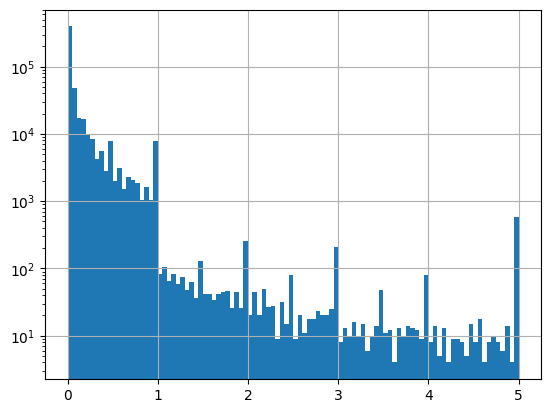

In [12]:
(trace['ascii_rptd_vol_tx']/1_000_000).hist(bins=100, log=True)

### Diagnostic: Check Filtering Impact

In [13]:
# Filter 1: Identify dealer-to-customer trades
# Typically: rptd_side_cd = 'B' (buy) or 'S' (sell), cntra_mp_id indicates dealer
# Adjust based on actual column names

print(f"Before filtering: {len(trace):,} records\n")

# Generic filter - adjust column names based on actual data
# Common columns: rptd_side_cd, cntra_mp_id, buyer_capacity, seller_capacity

trace_clean = trace.copy()

# Filter 2: Trade size >= $100,000
# Adjust column name - typically 'entrd_vol_qt' or 'rptd_pr'
if 'ascii_rptd_vol_tx' in trace_clean.columns:
    trace_clean = trace_clean[trace_clean['ascii_rptd_vol_tx'] >= 100_000]
    print(f"After size filter (≥$100k): {len(trace_clean):,} records")
else:
    print("[WARNING] Volume column not found - skipping size filter")

# Filter 3: Trading hours (9:30 AM - 4:00 PM ET)
if 'trd_exctn_tm' in trace_clean.columns:
    # Convert to time if needed
    if pd.api.types.is_datetime64_any_dtype(trace_clean['trd_exctn_tm']):
        trace_clean['trade_time'] = pd.to_datetime(trace_clean['trd_exctn_tm']).dt.time
    else:
        # Assume it's already time or parse as needed
        trace_clean['trade_time'] = pd.to_datetime(trace_clean['trd_exctn_tm'], format='%H:%M:%S').dt.time
    
    market_open = time(6, 30)
    market_close = time(20, 0)
    trace_clean = trace_clean[
        (trace_clean['trade_time'] >= market_open) & 
        (trace_clean['trade_time'] <= market_close)
    ]
    print(f"After trading hours filter: {len(trace_clean):,} records")

print(f"\nFinal clean records: {len(trace_clean):,}")

Before filtering: 586,003 records

After size filter (≥$100k): 118,235 records
After trading hours filter: 117,941 records

Final clean records: 117,941


After size filter (≥$100k): 118,235 records
After trading hours filter: 117,941 records

Final clean records: 117,941


In [14]:
trace_clean.columns.tolist()

['Unnamed: 0',
 'cusip_id',
 'bond_sym_id',
 'company_symbol',
 'bsym',
 'trd_exctn_dt',
 'trd_exctn_tm',
 'sub_prd_type',
 'trans_dt',
 'msg_seq_nb',
 'trc_st',
 'wis_fl',
 'cmsn_trd',
 'remuneration',
 'ascii_rptd_vol_tx',
 'frmt_cd',
 'rptd_pr',
 'yld_sign_cd',
 'yld_pt',
 'asof_cd',
 'days_to_sttl_ct',
 'sale_cndtn_cd',
 'sale_cndtn2_cd',
 'spcl_trd_fl',
 'diss_rptg_side_cd',
 'side',
 'chng_cd',
 'rptd_high_pr',
 'high_yld_sign_cd',
 'high_yld_pt',
 'rptd_low_pr',
 'low_yld_sign_cd',
 'low_yld_pt',
 'rptd_last_pr',
 'lsal_yld_sign_cd',
 'lsal_yld_pt',
 'orig_dis_dt',
 'orig_msg_seq_nb',
 'function',
 'sttl_dt',
 'rptg_party_type',
 'contra_party_type',
 'ats_indicator',
 'orig_frmt_cd',
 'orig_ascii_rptd_vol_tx',
 'orig_rptd_pr',
 'orig_remuneration',
 'orig_spcl_trd_fl',
 'orig_side',
 'orig_asof_cd',
 'orig_sale_cndtn_cd',
 'orig_sale_cndtn2_cd',
 'orig_sttl_dt',
 'orig_yld_sign_cd',
 'orig_yld_pt',
 'orig_wis_fl',
 'orig_rptg_party_type',
 'orig_contra_party_type',
 'orig_ats_i

In [15]:
hy_universe.columns.tolist()

['cusip_9',
 'isin',
 'issue_cusip',
 'complete_cusip',
 'issue_id',
 'maturity',
 'offering_date',
 'issue_name',
 'coupon_type',
 'coupon_type_label',
 'offering_yield',
 'security_level',
 'seniority',
 'bond_type',
 'offering_amt',
 'principal_amt',
 'issuer_id',
 'cusip_name',
 'industry_group',
 'industry_code',
 'naics_code',
 'naics_2digit',
 'sector',
 'rating',
 'rating_type',
 'rating_date',
 'convertible',
 'redeemable',
 'putable',
 'rule_144a',
 'amount_outstanding',
 'amount_outstanding_date',
 'rating_broad']

In [16]:
trace_clean = pd.merge(trace_clean, 
                       hy_universe.rename(columns = {'cusip_9' : 'cusip_id'}),
                       on = 'cusip_id', how = 'inner')

In [17]:
trace_clean['rating_broad'].unique()

array(['BB', 'B', 'CCC', 'CC', 'D', 'C'], dtype=object)

In [18]:
trace_clean['tradeDate'] = pd.to_datetime(trace_clean['trd_exctn_dt']).dt.date

In [19]:
trace_clean.groupby(['tradeDate'])['cusip_id'].nunique().describe()

count    162.000000
mean     308.518519
std       56.405169
min        2.000000
25%      293.000000
50%      315.500000
75%      335.000000
max      432.000000
Name: cusip_id, dtype: float64

In [20]:
# Filter 4: Keep only last trade per day per CUSIP
# Identify CUSIP column
cusip_col = 'cusip_id' if 'cusip_id' in trace_clean.columns else 'cusip'
date_col = 'trd_exctn_dt'
price_col = 'rptd_pr' if 'rptd_pr' in trace_clean.columns else 'price'

# Sort by date and time, keep last
if 'trd_exctn_tm' in trace_clean.columns:
    trace_clean = trace_clean.sort_values([date_col, 'trd_exctn_tm'])
else:
    trace_clean = trace_clean.sort_values([date_col])

# Keep last trade per day per CUSIP
trace_daily = (
    trace_clean
    .groupby([cusip_col, date_col])
    .tail(1)
    .reset_index(drop=True)
)

print(f"Daily trades (last per CUSIP per day): {len(trace_daily):,}")
print(f"Unique CUSIPs traded: {trace_daily[cusip_col].nunique():,}")
print(f"Unique dates: {trace_daily[date_col].nunique():,}")

# Rename columns for consistency
trace_daily = trace_daily.rename(columns={
    cusip_col: 'cusip',
    date_col: 'date',
    price_col: 'price'
})

# Ensure cusip matches universe (9-character)
if 'cusip' in trace_daily.columns:
    trace_daily['cusip_9'] = trace_daily['cusip'].str[:9]

trace_daily[['cusip_9', 'date', 'price']].head(20)

Daily trades (last per CUSIP per day): 49,980
Unique CUSIPs traded: 660
Unique dates: 162


,cusip_9,date,price
0,172967PM7,2025-01-02,106.182000
1,63938CAK4,2025-01-02,98.017000
2,88732JBD9,2025-01-02,74.966000
3,517834AE7,2025-01-02,97.668000
4,345397C35,2025-01-02,104.818000
5,988498AN1,2025-01-02,89.027000
6,382550BN0,2025-01-02,92.256000
7,058498AX4,2025-01-02,85.380000
8,48666KAZ2,2025-01-02,88.626000
9,69331CAH1,2025-01-02,97.873000


In [21]:
def prepare_features(bonds_df, reference_date, include_lagged_price=False, lagged_prices=None, feature_columns=None):
    """
    Prepare feature matrix for regression.
    
    Parameters:
    -----------
    bonds_df : DataFrame
        Bond characteristics (from hy_universe)
    reference_date : datetime
        Date for calculating time-varying features
    include_lagged_price : bool
        Whether to include previous day's price as feature
    lagged_prices : Series
        Previous day's prices (indexed by cusip_9)
    feature_columns : list, optional
        If provided, align output to have exactly these columns
    
    Returns:
    --------
    X : DataFrame
        Feature matrix
    feature_names : list
        Feature names after one-hot encoding
    """
    df = bonds_df.copy()
    
    # Time-varying features
    df['days_to_maturity'] = (df['maturity'] - reference_date).dt.days
    df['years_to_maturity'] = df['days_to_maturity'] / 365.25
    df['days_since_issue'] = (reference_date - df['offering_date']).dt.days
    df['years_since_issue'] = df['days_since_issue'] / 365.25
    
    # Handle missing values
    # Amount outstanding: fill with sector/rating median, then convert to millions
    if 'amount_outstanding' in df.columns:
        sector_rating_median = df.groupby(['sector', 'rating_broad'])['amount_outstanding'].transform('median')
        df['amount_outstanding'] = df['amount_outstanding'].fillna(sector_rating_median)
        df['amount_outstanding'] = df['amount_outstanding'].fillna(df['amount_outstanding'].median())
        # Convert to millions for better scale
        df['amount_outstanding_mm'] = df['amount_outstanding'] / 1_000_000
    
    # Offering yield: fill with rating median
    if 'offering_yield' in df.columns:
        rating_median = df.groupby('rating_broad')['offering_yield'].transform('median')
        df['offering_yield'] = df['offering_yield'].fillna(rating_median)
        df['offering_yield'] = df['offering_yield'].fillna(df['offering_yield'].median())
    
    # Numerical features
    numerical_features = []
    if 'amount_outstanding' in df.columns:
        numerical_features.append('amount_outstanding_mm')
    if 'offering_yield' in df.columns:
        numerical_features.append('offering_yield')
    numerical_features.extend(['years_to_maturity', 'years_since_issue'])
    
    # Categorical features (to be one-hot encoded)
    categorical_features = []
    if 'sector' in df.columns:
        categorical_features.append('sector')
    if 'rating_broad' in df.columns:
        categorical_features.append('rating_broad')
    if 'seniority' in df.columns:
        categorical_features.append('seniority')
    if 'coupon_type_label' in df.columns:
        categorical_features.append('coupon_type_label')
    
    # Binary features - map Y/N to 1/0
    binary_features = []
    for feat in ['putable', 'redeemable', 'convertible', 'rule_144a']:
        if feat in df.columns:
            # Map 'Y' to 1, everything else ('N', NaN, etc.) to 0
            df[feat] = (df[feat] == 'Y').astype(int)
            binary_features.append(feat)
    
    # Build feature matrix
    X = pd.DataFrame(index=df.index)
    
    # Add numerical features
    for feat in numerical_features:
        X[feat] = df[feat]
    
    # Add binary features
    for feat in binary_features:
        X[feat] = df[feat]
    
    # One-hot encode categorical features
    for feat in categorical_features:
        dummies = pd.get_dummies(df[feat], prefix=feat, drop_first=True)
        X = pd.concat([X, dummies], axis=1)
    
    # Add lagged price if requested
    if include_lagged_price and lagged_prices is not None:
        X['lagged_price'] = df['cusip_9'].map(lagged_prices)
        X['lagged_price'] = X['lagged_price'].fillna(X['lagged_price'].median())
    
    # Fill any remaining NaNs
    X = X.fillna(0)
    
    # Align to expected feature columns if provided
    if feature_columns is not None:
        # Add missing columns as zeros
        for col in feature_columns:
            if col not in X.columns:
                X[col] = 0
        # Keep only the expected columns in the same order
        X = X[feature_columns]
    
    return X, list(X.columns)

print("Feature engineering function defined")

Feature engineering function defined


In [22]:
trace_hy = trace_daily

In [23]:
# Define SIFMA bond market holidays for 2025
sifma_holidays_2025 = [
    '2025-01-01',  # New Year's Day
    '2025-01-20',  # Martin Luther King Jr. Day
    '2025-02-17',  # Presidents Day
    '2025-04-18',  # Good Friday
    '2025-05-26',  # Memorial Day
    '2025-07-04',  # Independence Day
    '2025-09-01',  # Labor Day
    '2025-10-13',  # Columbus Day
    '2025-11-11',  # Veterans Day
    '2025-11-27',  # Thanksgiving
    '2025-12-25',  # Christmas
]

# Convert to datetime
sifma_holidays = pd.to_datetime(sifma_holidays_2025).date

print("SIFMA Bond Market Holidays 2025:")
for holiday in sifma_holidays:
    print(f"  {holiday}")

# Filter to trading days only
print(f"\nBefore filtering: {len(trace_hy):,} trades on {trace_hy['date'].nunique()} unique dates")

# Remove weekends
trace_hy['is_weekend'] = trace_hy['date'].dt.dayofweek.isin([5, 6])  # Saturday=5, Sunday=6
weekends_removed = trace_hy['is_weekend'].sum()

# Remove holidays
trace_hy['is_holiday'] = trace_hy['date'].dt.date.isin(sifma_holidays)
holidays_removed = trace_hy['is_holiday'].sum()

# Keep only trading days
trace_hy = trace_hy[~(trace_hy['is_weekend'] | trace_hy['is_holiday'])].copy()
trace_hy = trace_hy.drop(columns=['is_weekend', 'is_holiday'])

print(f"\nRemoved:")
print(f"  Weekends: {weekends_removed:,} trades")
print(f"  Holidays: {holidays_removed:,} trades")

print(f"\nAfter filtering: {len(trace_hy):,} trades on {trace_hy['date'].nunique()} trading days")

# Verify no weekends remain
remaining_weekends = trace_hy['date'].dt.dayofweek.isin([5, 6]).sum()
remaining_holidays = trace_hy['date'].dt.date.isin(sifma_holidays).sum()
print(f"\nVerification:")
print(f"  Remaining weekend trades: {remaining_weekends}")
print(f"  Remaining holiday trades: {remaining_holidays}")

SIFMA Bond Market Holidays 2025:
  2025-01-01
  2025-01-20
  2025-02-17
  2025-04-18
  2025-05-26
  2025-07-04
  2025-09-01
  2025-10-13
  2025-11-11
  2025-11-27
  2025-12-25

Before filtering: 49,980 trades on 162 unique dates

Removed:
  Weekends: 0 trades
  Holidays: 5 trades

After filtering: 49,975 trades on 160 trading days

Verification:
  Remaining weekend trades: 0
  Remaining holiday trades: 0


### Filter to Trading Days Only

Remove weekends and SIFMA bond market holidays

## 4. Feature Engineering

In [24]:
def prepare_features(bonds_df, reference_date, include_lagged_price=False, lagged_prices=None, feature_columns=None):
    """
    Prepare feature matrix for regression.
    
    Parameters:
    -----------
    bonds_df : DataFrame
        Bond characteristics (from hy_universe)
    reference_date : datetime
        Date for calculating time-varying features
    include_lagged_price : bool
        Whether to include previous day's price as feature
    lagged_prices : Series
        Previous day's prices (indexed by cusip_9)
    feature_columns : list, optional
        If provided, align output to have exactly these columns
    
    Returns:
    --------
    X : DataFrame
        Feature matrix
    feature_names : list
        Feature names after one-hot encoding
    """
    df = bonds_df.copy()
    
    # Time-varying features
    df['days_to_maturity'] = (df['maturity'] - reference_date).dt.days
    df['years_to_maturity'] = df['days_to_maturity'] / 365.25
    df['days_since_issue'] = (reference_date - df['offering_date']).dt.days
    df['years_since_issue'] = df['days_since_issue'] / 365.25
    
    # Handle missing values
    # Amount outstanding: fill with sector/rating median
    if 'amount_outstanding' in df.columns:
        sector_rating_median = df.groupby(['sector', 'rating_broad'])['amount_outstanding'].transform('median')
        df['amount_outstanding'] = df['amount_outstanding'].fillna(sector_rating_median)
        df['amount_outstanding'] = df['amount_outstanding'].fillna(df['amount_outstanding'].median())
    
    # Offering yield: fill with rating median
    if 'offering_yield' in df.columns:
        rating_median = df.groupby('rating_broad')['offering_yield'].transform('median')
        df['offering_yield'] = df['offering_yield'].fillna(rating_median)
        df['offering_yield'] = df['offering_yield'].fillna(df['offering_yield'].median())
    
    # Numerical features
    numerical_features = []
    if 'amount_outstanding' in df.columns:
        numerical_features.append('amount_outstanding')
    if 'offering_yield' in df.columns:
        numerical_features.append('offering_yield')
    numerical_features.extend(['years_to_maturity', 'years_since_issue'])
    
    # Categorical features (to be one-hot encoded)
    categorical_features = []
    if 'sector' in df.columns:
        categorical_features.append('sector')
    if 'rating_broad' in df.columns:
        categorical_features.append('rating_broad')
    if 'seniority' in df.columns:
        categorical_features.append('seniority')
    if 'coupon_type_label' in df.columns:
        categorical_features.append('coupon_type_label')
    
    # Binary features - map Y/N to 1/0
    binary_features = []
    for feat in ['putable', 'redeemable', 'convertible', 'rule_144a']:
        if feat in df.columns:
            # Map 'Y' to 1, everything else ('N', NaN, etc.) to 0
            df[feat] = (df[feat] == 'Y').astype(int)
            binary_features.append(feat)
    
    # Build feature matrix
    X = pd.DataFrame(index=df.index)
    
    # Add numerical features
    for feat in numerical_features:
        X[feat] = df[feat]
    
    # Add binary features
    for feat in binary_features:
        X[feat] = df[feat]
    
    # One-hot encode categorical features
    for feat in categorical_features:
        dummies = pd.get_dummies(df[feat], prefix=feat, drop_first=True)
        X = pd.concat([X, dummies], axis=1)
    
    # Add lagged price if requested
    if include_lagged_price and lagged_prices is not None:
        X['lagged_price'] = df['cusip_9'].map(lagged_prices)
        X['lagged_price'] = X['lagged_price'].fillna(X['lagged_price'].median())
    
    # Fill any remaining NaNs
    X = X.fillna(0)
    
    # Align to expected feature columns if provided
    if feature_columns is not None:
        # Add missing columns as zeros
        for col in feature_columns:
            if col not in X.columns:
                X[col] = 0
        # Keep only the expected columns in the same order
        X = X[feature_columns]
    
    return X, list(X.columns)

print("Feature engineering function defined")

Feature engineering function defined


## Export Merged Data

In [25]:
# Export TRACE data with all bond metadata columns
output_file = "trace_hy_merged.csv"
trace_hy.to_csv(output_file, index=False)

print("=" * 80)
print("DATA PREPARATION COMPLETE")
print("=" * 80)
print(f"\nOutput: {output_file}")
print(f"Records: {len(trace_hy):,}")
print(f"Unique bonds: {trace_hy['cusip_9'].nunique():,}")
print(f"Trading days: {trace_hy['date'].nunique():,}")
print(f"Date range: {trace_hy['date'].min()} to {trace_hy['date'].max()}")
print(f"\nColumns: {len(trace_hy.columns)}")
print(f"File size: {Path(output_file).stat().st_size / 1024 / 1024:.1f} MB")
print("\n" + "=" * 80)
print("✓ Ready for modeling (02_hy_daily_pricing_model.ipynb)")
print("=" * 80)


DATA PREPARATION COMPLETE

Output: trace_hy_merged.csv
Records: 49,975
Unique bonds: 660
Trading days: 160
Date range: 2025-01-02 00:00:00 to 2025-08-20 00:00:00

Columns: 101
File size: 22.1 MB

✓ Ready for modeling (02_hy_daily_pricing_model.ipynb)
